In [1]:
from orphics import maps
import numpy as np

import camb

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#(Ωb,Ωm,ΩΛ,h,ns,σ8)
#Omb, Om, OL, h, ns, sig8 = (0.044, 0.264, 0.736, 0.71, 0.96, 0.80) 

In [3]:
lmax = 7000

In [4]:
h*100

71.0

In [3]:
ini_filename = '../input/sehgal.ini'
pars = camb.read_ini(ini_filename)

In [7]:
#pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
#pars.set_cosmology(H0 = h*100, ombh2 = Omb*h**2, omch2 = (Om-Omb)*h**2, mnu = 0, omk = 0.0, tau =  0.087)
#pars.InitPower.set_params(As = 2.4e-9, ns = ns, r = 0)
#pars.set_for_lmax(lmax, lens_potential_accuracy = 4)

In [4]:
pars.set_matter_power(redshifts=[0.], kmax = 10.0)
#Linear spectra
pars.NonLinear = camb.model.NonLinear_none
results = camb.get_results(pars)
s8 = np.array(results.get_sigma8())

In [5]:
s8

array([0.79620817])

In [6]:
#calculate results for these parameters
results = camb.get_results(pars)

In [7]:
powers =results.get_cmb_power_spectra(pars, CMB_unit = 'muK')
for name in powers: 
    print(name)

total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential


In [20]:
ls = np.arange(powers['unlensed_scalar'].shape[0])

In [21]:
np.savetxt('../input/Sehgal_lenspotentialCls.dat', np.c_[ls, powers['unlensed_scalar'], powers['lens_potential']])

In [24]:
#np.savetxt('_lensedCls.dat', np.c_[ls, totCL])

In [25]:
#np.savetxt('_scalCls.dat', np.c_[ls, unlensedCL])

In [57]:
gcls = results.get_lensed_gradient_cls(lmax = 19901, CMB_unit = 'muK', raw_cl = True)

In [45]:
ll = gcls.shape[0]
factorll = ll*(ll+1)/(2*np.pi)

In [39]:
grad = np.loadtxt('/global/homes/o/omard/so-lenspipe/data/cosmo2017_10K_acc3_camb_1.0.12_grads.dat')

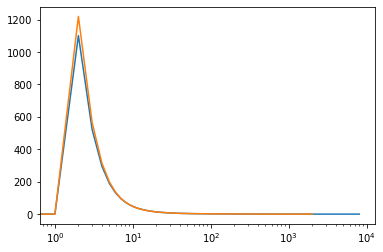

In [55]:
plt.plot(grad[:, 1])
plt.plot(gcls[:, 0])
plt.xscale('log')

In [62]:
#np.savetxt('_camb_1.0.12_grads.dat', np.c_[ls, gcls[:-1, :]])

In [13]:
lssehgal, clssehgal = np.loadtxt('/global/cscratch1/sd/omard/scatteringtfms/sims/CMB_PS_healpix_Nside4096_DeltaT_uK_SimLensCMB.txt', unpack = True)

In [14]:
factor = lssehgal*(lssehgal+1)/(2*np.pi)

In [15]:
L, TT, EE, BB, TE  = np.loadtxt('lensed_sehgal_mat.dat', unpack = True)
Lfac = L*(L+1)/(2*np.pi)

(19901, 4)


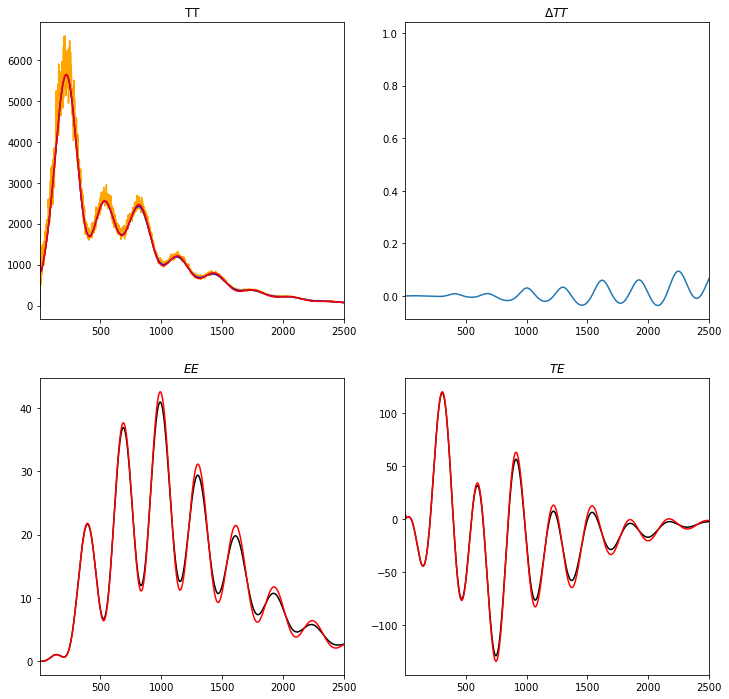

In [16]:
#plot the total lensed CMB power spectra versus unlensed, and fractional difference
totCL=powers['total']
unlensedCL=powers['unlensed_scalar']
print(totCL.shape)
#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
ls = np.arange(totCL.shape[0])
fig, ax = plt.subplots(2,2, figsize = (12,12))
ax[0,0].plot(ls,totCL[:,0], color='k')
ax[0,0].plot(lssehgal, clssehgal*factor, color='orange')
ax[0,0].plot(L, TT, color='blue')
ax[0,0].plot(ls,unlensedCL[:,0], color='r')
ax[0,0].set_title('TT')
ax[0,1].plot(ls[2:], 1-unlensedCL[2:,0]/totCL[2:,0]);
ax[0,1].set_title(r'$\Delta TT$')
ax[1,0].plot(ls,totCL[:,1], color='k')
ax[1,0].plot(ls,unlensedCL[:,1], color='r')
ax[1,0].set_title(r'$EE$')
ax[1,1].plot(ls,totCL[:,3], color='k')
ax[1,1].plot(ls,unlensedCL[:,3], color='r')
ax[1,1].set_title(r'$TE$');
for ax in ax.reshape(-1): ax.set_xlim([2,2500]);

In [ ]:
def get_theory_dicts(nells=None,lmax=9000,grad=True):
    thloc = os.path.dirname(os.path.abspath(__file__)) + "/../data/" + config['theory_root']
    ls = np.arange(lmax+1)
    ucls = {}
    tcls = {}
    theory = cosmology.loadTheorySpectraFromCAMB(thloc,get_dimensionless=False)
    ells,gt,ge,gb,gte = np.loadtxt(f"{thloc}_camb_1.0.12_grads.dat",unpack=True,usecols=[0,1,2,3,4])
    if nells is None: nells = {'TT':0,'EE':0,'BB':0}
    ucls['TT'] = maps.interp(ells,gt)(ls) if grad else theory.lCl('TT',ls)
    ucls['TE'] = maps.interp(ells,gte)(ls) if grad else theory.lCl('TE',ls)
    ucls['EE'] = maps.interp(ells,ge)(ls) if grad else theory.lCl('EE',ls)
    ucls['BB'] = maps.interp(ells,gb)(ls) if grad else theory.lCl('BB',ls)
    ucls['kk'] = theory.gCl('kk',ls)
    tcls['TT'] = theory.lCl('TT',ls) + nells['TT']
    tcls['TE'] = theory.lCl('TE',ls)
    tcls['EE'] = theory.lCl('EE',ls) + nells['EE']
    tcls['BB'] = theory.lCl('BB',ls) + nells['BB']
    return ucls, tcls